In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
import requests
from io import StringIO

def download_csv_data(url):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Check if the request was successful
        # Load CSV with specified delimiter and correct column names
        data = pd.read_csv(StringIO(response.text), delimiter=';', low_memory=False)
        print(f"Columns in the dataset: {data.columns.tolist()}")  # Debug statement
        return data
    except Exception as e:
        print(f"An error occurred while downloading the CSV file: {e}")
        return None

def load_neighborhood_data(file_path):
    data = pd.read_excel(file_path)
    print(f"Columns in the neighborhood data: {data.columns.tolist()}")  # Debug statement
    return data

def preprocess_data(data):
    print(f"Initial data size: {data.shape}")  # Debug statement
    if 'entrydate' in data.columns:
        data['entrydate'] = pd.to_datetime(data['entrydate'], errors='coerce')
    else:
        raise ValueError("Date column 'entrydate' not found in the dataset")
    
    # Dropping rows with missing values in critical columns only
    data = data.dropna(subset=['infractiontext', 'block', 'entrydate', 'street'])
    print(f"Data size after dropping NAs: {data.shape}")  # Debug statement
    
    # Remove duplicate entries if any
    data = data.drop_duplicates()
    print(f"Data size after dropping duplicates: {data.shape}")  # Debug statement
    
    return data

def create_combined_key(data):
    data['CombinedKey'] = data['block'].astype(str) + ' ' + data['street'].str.upper().str.strip()
    return data

def merge_data(parking_data, neighborhood_data):
    parking_data = create_combined_key(parking_data)
    neighborhood_data['HBLOCK'] = neighborhood_data['HBLOCK'].str.upper().str.strip()
    merged_data = pd.merge(parking_data, neighborhood_data, how='left', left_on='CombinedKey', right_on='HBLOCK')
    print(f"Merged data size: {merged_data.shape}")  # Debug statement
    return merged_data

def filter_data(data, bylaw_descriptions):
    filtered_data = data[data['infractiontext'].isin(bylaw_descriptions)]
    print(f"Filtered data size: {filtered_data.shape}")  # Debug statement
    return filtered_data

def unique_hundred_blocks(data, specific_infraction, month, year):
    specific_date_data = data[
        (data['entrydate'].dt.month == month) &
        (data['entrydate'].dt.year == year) &
        (data['infractiontext'] == specific_infraction)
    ]
    return specific_date_data['block'].nunique()

def generate_heat_map(data, output_file):
    if 'NEIGHBORHOOD' in data.columns:
        neighborhood_counts = data['NEIGHBORHOOD'].value_counts().reset_index()
        neighborhood_counts.columns = ['Neighborhood', 'Count']
        # Create a map centered around Vancouver
        heat_map = folium.Map(location=[49.2827, -123.1207], zoom_start=12)
        
        # Add the counts to the heat map
        for _, row in neighborhood_counts.iterrows():
            folium.CircleMarker(
                location=[49.2827, -123.1207],  # Center the map roughly around Vancouver
                radius=row['Count'] / 10,  # Scale the circle size
                popup=f"{row['Neighborhood']}: {row['Count']} tickets",
                color='crimson',
                fill=True,
                fill_color='crimson'
            ).add_to(heat_map)
        
        heat_map.save(output_file)
    else:
        print("Neighborhood data not found in the dataset")

def monthly_trend_analysis(data, bylaw_descriptions):
    filtered_data = data[data['infractiontext'].isin(bylaw_descriptions)]
    monthly_trend = filtered_data.resample('M', on='entrydate').size()
    return monthly_trend

def most_frequent_ticket(data, neighborhood):
    if 'NEIGHBORHOOD' in data.columns:
        data['NEIGHBORHOOD'] = data['NEIGHBORHOOD'].str.upper().str.strip()
        neighborhood_data = data[data['NEIGHBORHOOD'].str.contains(neighborhood.upper().strip(), case=False, na=False)]
        if not neighborhood_data.empty:
            return neighborhood_data['infractiontext'].mode()[0]
        else:
            return "No data available"
    else:
        return "Neighborhood data not found"

def save_plot(monthly_trend, output_file):
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_trend.index, monthly_trend.values, marker='o')
    plt.title('Monthly Trend of Stopping Tickets')
    plt.xlabel('Date')
    plt.ylabel('Number of Tickets')
    plt.grid(True)
    plt.savefig(output_file)
    plt.show()

def generate_report(year, month, bylaw_descriptions, neighborhood, neighborhood_file):
    parking_data = download_csv_data("https://opendata.vancouver.ca/api/v2/catalog/datasets/parking-tickets/exports/csv")
    if parking_data is None:
        print(f"No data found for {year}-{month}")
        return
    
    neighborhood_data = load_neighborhood_data(neighborhood_file)
    parking_data = preprocess_data(parking_data)
    
    merged_data = merge_data(parking_data, neighborhood_data)
    
    # Debug: Check merged data before filtering
    print(f"Merged data before filtering: {merged_data.head()}")

    # Ensure neighborhood data is present if available
    if 'NEIGHBORHOOD' in merged_data.columns:
        merged_data['NEIGHBORHOOD'] = merged_data['NEIGHBORHOOD'].fillna('UNKNOWN')
    
    filtered_data = filter_data(merged_data, bylaw_descriptions)
    
    # Debug: Check filtered data
    print(f"Filtered data: {filtered_data.head()}")
    
    specific_infraction = 'STOP AT A PLACE WHERE A TRAFFIC SIGN PROHIBITS STOPPING'
    # Additional debug: Check unique blocks in different stages
    initial_unique_blocks = unique_hundred_blocks(parking_data, specific_infraction, month, year)
    merged_unique_blocks = unique_hundred_blocks(merged_data, specific_infraction, month, year)
    filtered_unique_blocks = unique_hundred_blocks(filtered_data, specific_infraction, month, year)
    
    print(f"Initial unique hundred-blocks: {initial_unique_blocks}")
    print(f"Unique hundred-blocks after merging: {merged_unique_blocks}")
    print(f"Unique hundred-blocks after filtering: {filtered_unique_blocks}")

    # Validate unique hundred-blocks similar to reference script
    specific_date_data = parking_data[
        (parking_data['entrydate'].dt.month == month) &
        (parking_data['entrydate'].dt.year == year) &
        (parking_data['infractiontext'] == specific_infraction)
    ]
    unique_blocks_reference = specific_date_data['block'].nunique()
    print(f"Reference unique hundred-blocks for '{specific_infraction}' in {month}/{year}: {unique_blocks_reference}")
    
    # Generate the heat map based on neighborhood counts
    heat_map_file = f"heat_map_{month}_{year}.html"
    generate_heat_map(filtered_data, heat_map_file)
    
    monthly_trend = monthly_trend_analysis(filtered_data, bylaw_descriptions)
    plot_file = f"monthly_trend_{bylaw_descriptions}.png"
    save_plot(monthly_trend, plot_file)
    
    most_frequent = most_frequent_ticket(merged_data, neighborhood)
    print(f"Most frequent type of ticket in {neighborhood} in {month}/{year}: {most_frequent}")

def main():
    bylaw_descriptions = [
        'STOP AT A PLACE WHERE A TRAFFIC SIGN PROHIBITS STOPPING',
        # Add more descriptions as needed
    ]
    periods = [
        {'year': 2023, 'month': 7},
        # Add more periods as needed
    ]
    neighborhood = 'Kensington'
    neighborhood_file = "StreetCentreline_HundredBlock.xlsx"  # Updated file path
    
    for period in periods:
        year = period['year']
        month = period['month']
        generate_report(year, month, bylaw_descriptions, neighborhood, neighborhood_file)

if __name__ == "__main__":
    main()

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
import requests
from io import StringIO

# Function to download CSV data from a URL
def download_csv_data(url):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Check if the request was successful
        data = pd.read_csv(StringIO(response.text), delimiter=';', low_memory=False)
        print(f"Columns in the dataset: {data.columns.tolist()}")  # Debug statement
        return data
    except Exception as e:
        print(f"An error occurred while downloading the CSV file: {e}")
        return None

# Function to load neighborhood data from an Excel file
def load_neighborhood_data(file_path):
    data = pd.read_excel(file_path)
    print(f"Columns in the neighborhood data: {data.columns.tolist()}")  # Debug statement
    return data

# Function to preprocess data
def preprocess_data(data):
    print(f"Initial data size: {data.shape}")  # Debug statement
    if 'entrydate' in data.columns:
        data['entrydate'] = pd.to_datetime(data['entrydate'], errors='coerce')
    else:
        raise ValueError("Date column 'entrydate' not found in the dataset")
    
    # Fill missing values in 'infractiontext' with 'Unknown'
    data['infractiontext'] = data['infractiontext'].fillna('Unknown')
    
    # Dropping rows with missing values in critical columns only
    data = data.dropna(subset=['entrydate'])
    print(f"Data size after dropping NAs: {data.shape}")  # Debug statement
    
    # Remove duplicate entries if any
    data = data.drop_duplicates()
    print(f"Data size after dropping duplicates: {data.shape}")  # Debug statement
    
    return data

# Function to perform basic analysis
def basic_analysis(data):
    print(f"Total number of records: {len(data)}")
    print(f"Number of unique infractions: {data['infractiontext'].nunique()}")
    print(f"Top 5 most common infractions:\n{data['infractiontext'].value_counts().head()}")


Columns in the dataset: ['block', 'street', 'entrydate', 'bylaw', 'section', 'status', 'infractiontext', 'year', 'bi_id']
Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1803280 entries, 0 to 1803279
Data columns (total 9 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   block           int64 
 1   street          object
 2   entrydate       object
 3   bylaw           int64 
 4   section         object
 5   status          object
 6   infractiontext  object
 7   year            int64 
 8   bi_id           int64 
dtypes: int64(4), object(5)
memory usage: 123.8+ MB
None
First 5 Rows of Data:
   block      street   entrydate  bylaw      section status  \
0   2000  W 41ST AVE  2020-01-04   2952  5(4)(A)(ii)     IS   
1   2000  W 41ST AVE  2020-01-04   2952  5(4)(A)(ii)     IS   
2   5900   EAST BLVD  2020-01-04   2849         21.1     IS   
3    400  W 64TH AVE  2020-01-04   2849      17.6(B)     IS   
4    500   ABBOTT ST  2020-01-04   2849       

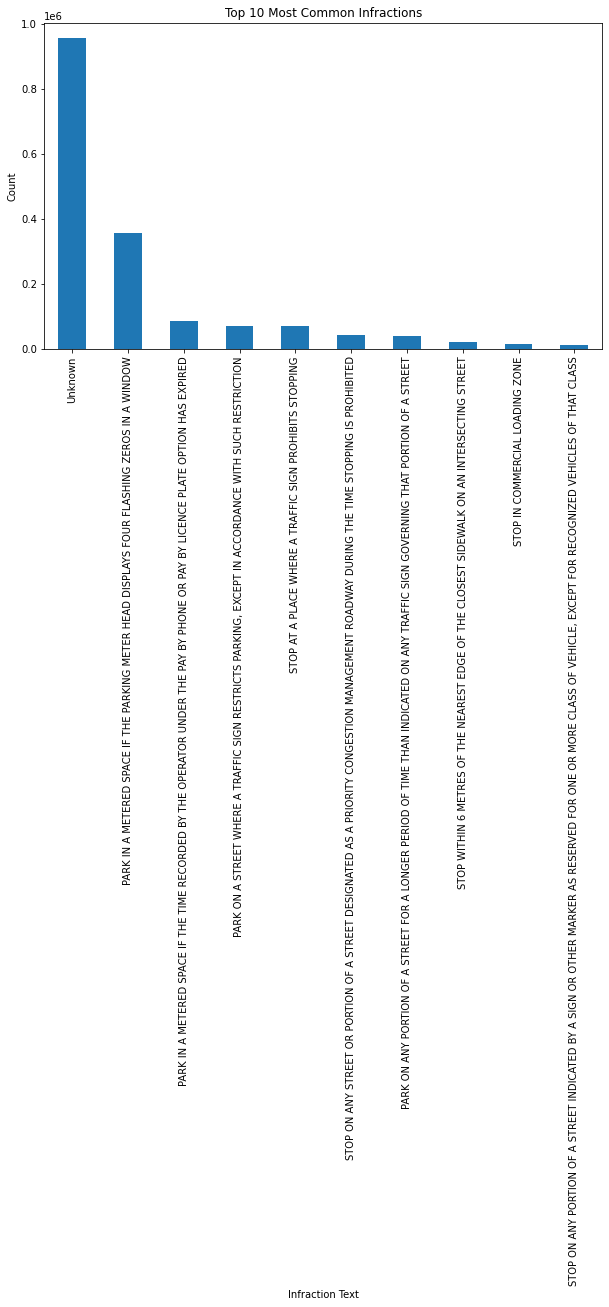

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
from io import StringIO

# Function to download CSV data from a URL
def download_csv_data(url):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Check if the request was successful
        data = pd.read_csv(StringIO(response.text), delimiter=';', low_memory=False)
        print(f"Columns in the dataset: {data.columns.tolist()}")  # Debug statement
        return data
    except Exception as e:
        print(f"An error occurred while downloading the CSV file: {e}")
        return None

# Function to inspect data
def inspect_data(data):
    print("Data Information:")
    print(data.info())
    print("First 5 Rows of Data:")
    print(data.head())
    print("Null values in each column:")
    print(data.isnull().sum())

# Function to clean data
def clean_data(data):
    # Fill missing values in 'infractiontext' with 'Unknown'
    data['infractiontext'].fillna('Unknown', inplace=True)
    
    # Convert 'entrydate' to datetime and extract date only
    data['entrydate'] = pd.to_datetime(data['entrydate'], errors='coerce').dt.date
    
    # Remove duplicate entries
    data.drop_duplicates(inplace=True)
    
    # Confirm no missing values remain
    print("Null values after cleaning:")
    print(data.isnull().sum())
    
    # Confirm data types
    print("Data types after cleaning:")
    print(data.dtypes)
    
    return data

# Function to perform basic analysis
def basic_analysis(data):
    print("Data quality checks:")
    print(data.describe(include='all'))
    
    print(f"Total number of records: {len(data)}")
    print(f"Number of unique infractions: {data['infractiontext'].nunique()}")
    print(f"Top 5 most common infractions:\n{data['infractiontext'].value_counts().head()}")

# Function to generate basic bar charts
def generate_bar_charts(data):
    # Bar chart for the most common infractions
    top_infractions = data['infractiontext'].value_counts().head(10)
    top_infractions.plot(kind='bar', figsize=(10, 6), title='Top 10 Most Common Infractions')
    plt.xlabel('Infraction Text')
    plt.ylabel('Count')
    plt.show()
    
    # Bar chart for infractions over time
    data.set_index('entrydate', inplace=True)
    infractions_over_time = data.resample('M')['infractiontext'].count()
    infractions_over_time.plot(kind='bar', figsize=(12, 6), title='Monthly Infractions Over Time')
    plt.xlabel('Month')
    plt.ylabel('Number of Infractions')
    plt.show()

# Example usage
csv_url = "https://opendata.vancouver.ca/api/v2/catalog/datasets/parking-tickets/exports/csv"

# Download and preprocess data
parking_tickets = download_csv_data(csv_url)
if parking_tickets is not None:
    inspect_data(parking_tickets)
    cleaned_data = clean_data(parking_tickets)
    basic_analysis(cleaned_data)
    generate_bar_charts(cleaned_data)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from io import StringIO
from sklearn.cluster import KMeans

# Function to download CSV data from a URL
def download_csv_data(url):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Check if the request was successful
        data = pd.read_csv(StringIO(response.text), delimiter=';', low_memory=False)
        print(f"Columns in the dataset: {data.columns.tolist()}")  # Debug statement
        return data
    except Exception as e:
        print(f"An error occurred while downloading the CSV file: {e}")
        return None

# Function to inspect data
def inspect_data(data):
    print("Data Information:")
    print(data.info())
    print("First 5 Rows of Data:")
    print(data.head())
    print("Null values in each column:")
    print(data.isnull().sum())

# Function to clean data
def clean_data(data):
    # Ensure 'entrydate' is in datetime format, handling errors
    data['entrydate'] = pd.to_datetime(data['entrydate'], errors='coerce')
    
    # Fill missing values in 'infractiontext' with 'Unknown'
    data['infractiontext'].fillna('Unknown', inplace=True)
    
    # Convert 'entrydate' to datetime and extract date only
    data['entrydate'] = data['entrydate'].dt.date
    
    # Remove duplicate entries
    data.drop_duplicates(inplace=True)
    
    # Extract necessary time features
    data['Year'] = pd.to_datetime(data['entrydate']).dt.year
    data['Month'] = pd.to_datetime(data['entrydate']).dt.month
    data['Day'] = pd.to_datetime(data['entrydate']).dt.day
    data['DayOfWeek'] = pd.to_datetime(data['entrydate']).dt.dayofweek
    
    # Confirm no missing values remain
    print("Null values after cleaning:")
    print(data.isnull().sum())
    
    # Confirm data types
    print("Data types after cleaning:")
    print(data.dtypes)
    
    return data

# Function to perform basic analysis
def basic_analysis(data):
    print("Data quality checks:")
    print(data.describe(include='all'))
    
    print(f"Total number of records: {len(data)}")
    print(f"Number of unique infractions: {data['infractiontext'].nunique()}")
    print(f"Top 5 most common infractions:\n{data['infractiontext'].value_counts().head()}")

# Function to generate basic bar charts
def generate_bar_charts(data):
    # Convert 'entrydate' back to datetime for plotting
    data['entrydate'] = pd.to_datetime(data['entrydate'])
    
    # Bar chart for the most common infractions
    top_infractions = data['infractiontext'].value_counts().head(10)
    top_infractions.plot(kind='bar', figsize=(10, 6), title='Top 10 Most Common Infractions')
    plt.xlabel('Infraction Text')
    plt.ylabel('Count')
    plt.show()
    
    # Set 'entrydate' as index and resample
    data.set_index('entrydate', inplace=True)
    infractions_over_time = data.resample('M')['infractiontext'].count()
    infractions_over_time.plot(kind='bar', figsize=(12, 6), title='Monthly Infractions Over Time')
    plt.xlabel('Month')
    plt.ylabel('Number of Infractions')
    plt.show()


# Example usage
csv_url = "https://opendata.vancouver.ca/api/v2/catalog/datasets/parking-tickets/exports/csv"

# Download and preprocess data
parking_tickets = download_csv_data(csv_url)
if parking_tickets is not None:
    inspect_data(parking_tickets)
    cleaned_data = clean_data(parking_tickets)
    basic_analysis(cleaned_data)
    generate_bar_charts(cleaned_data)

